<a href="https://colab.research.google.com/github/2020-nlp-c/nlp-deeplearning/blob/master/sojeong/Word2Vec_%EC%A1%B0%EC%86%8C%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
doc = "you will never know until you try"

In [3]:
doc_tokens = doc.split(" ")
doc_tokens

['you', 'will', 'never', 'know', 'until', 'you', 'try']

In [4]:
tokens = np.unique(doc_tokens)
tokens

array(['know', 'never', 'try', 'until', 'will', 'you'], dtype='<U5')

In [5]:
len(tokens)

6

In [6]:
def one_hot_encode(doc_tokens):
    # 고유 단어와 인덱스를 매칭시켜주는 사전 생성
    word2id_dic = defaultdict(lambda: len(word2id_dic))

    # {단어 : 인덱스} 사전 구축
    for word in doc_tokens:
        word2id_dic[word]

    n_unique_words = len(word2id_dic) # 고유한 단어의 갯수
    one_hot_vectors = np.zeros((len(doc_tokens), n_unique_words)) # 원핫-벡터를 만들기 위해 비어있는 벡터 생성

    for i, word in enumerate(doc_tokens):
        index = word2id_dic[word] # 해당 단어의 고유 인덱스
        one_hot_vectors[i, index] = 1 # 해당 단어의 고유 인덱스에만 1을 더해줌

    return one_hot_vectors

In [7]:
one_hot_vectors = one_hot_encode(doc_tokens)
one_hot_vectors

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [8]:
num_epoch = 10000
Window = 2
H = 4
alpha = 0.03
loss_epoch = []

# Weight
W1 = np.random.rand(len(tokens), H)
W2 = np.random.rand(H, len(tokens))

# 소프트맥스 함수
def softmax(a) :
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y

for epoch in range(num_epoch):
    loss = []
    for i, word in enumerate(doc_tokens):
        input_vec = []
        for j in range(1, Window+1):
            if i-j >= 0:
                input_vec.append(one_hot_vectors[i-j])
            try : input_vec.append(one_hot_vectors[i+j])
            except : pass

        Hidden = []
        for j in range(len(input_vec)):
            Hidden.append(np.dot(input_vec[j], W1))
        Hidden = np.sum(Hidden, axis=0) / len(input_vec)

        Predict = softmax(np.dot(Hidden, W2))

        for a in one_hot_vectors:
            L = -np.dot(a, np.log(Predict).reshape(len(Predict), 1))
            loss.extend(L)

        for i in one_hot_vectors:
            gradient_W2 = np.dot(Hidden.reshape(len(Hidden), 1), (Predict-i).reshape(1, len(Predict)))
            gradient_W1 = np.dot(input_vec[j].reshape(len(input_vec[j]), 1), np.dot(W2, (Predict-i)).reshape(1, len(W2)))

        W2 -= alpha * gradient_W2
        W1 -= alpha * gradient_W1

    loss_epoch.append(np.sum(L))

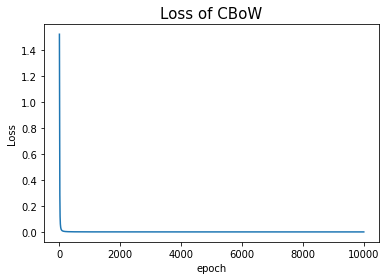

In [9]:
plt.plot(np.arange(num_epoch), loss_epoch)
plt.title("Loss of CBoW", size=15)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()